## Pipeline - SMOTE + Balanced RF + CV with KNN Imputation, along with Accuracy, Classification Report, Confusion Matrix and ROC - AUC Score. In feature engineering we have ER PR Bins.

Added - Reliability Curve, Brier Score, PR AUC Curve, 95% Confidence Intervals on ROC AUC and PR AUC Scores.

In [97]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils import resample
from patsy import dmatrix

In [98]:
df = pd.read_csv("/content/canbrs_dataset.csv")
df.head()

,ID,V1,var2,var3,var4,V5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,Outcome
0,A1,77,2010,w1,m1,509,98,0,Unknown,Unknown,Unknown,Unknown,3,Positive,Negative,Negative,Dead
1,A2,82,2010,w1,w5,501,98,0,Yes,No,No,No,3,Positive,Negative,Negative,Dead
2,A3,42,2011,w1,s3,509,98,0,Yes,No,Yes,Yes,1,Negative,Negative,Negative,Dead
3,A4,72,2012,w1,w5,509,98,0,No,No,No,Yes,1,Negative,Negative,Negative,Dead
4,A5,85,2013,w1,w5,508,98,0,Yes,No,No,No,4,Positive,Positive,Positive,Dead


In [99]:
data = df.copy()

In [100]:
# data['Age'] = data['V1']

# quantile_knots = np.quantile(data['Age'], [0.25, 0.5, 0.75])
# spline_age = dmatrix("bs(data['Age'], knots=quantile_knots, degree=3, include_intercept=False)",
#                      {"data": data}, return_type='dataframe')

# data = pd.concat([data, spline_age], axis=1)

In [101]:
def bin_status(status):
    if pd.isnull(status) or status == 'Unknown':
        return np.nan
    elif status == 'Negative':
        return 0  # Negative -> 0
    elif status == 'Positive':
        return 1  # Positive -> 1
    else:
        return np.nan

data['ER_bin'] = data['v13'].apply(bin_status)
data['PR_bin'] = data['v14'].apply(bin_status)

data = data.drop(['v13', 'v14'], axis=1)

## N-status derived (# positive nodes)

In [102]:
def map_n_status(row):
    count_positive = sum(row[col] == 'Yes' for col in ['v8', 'v9', 'v10', 'v11'])
    if count_positive == 0:
        return '0'
    elif 1 <= count_positive <= 3:
        return '1-3'
    else:
        return '4+'

In [103]:
le_outcome = LabelEncoder()
data['Outcome'] = le_outcome.fit_transform(data['Outcome'])

label_encoders = {}

label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

data = data.round().astype(int)

# N Status Added here.

# data['N_status'] = data.apply(map_n_status, axis=1)
# data['N_status_encoded'] = data['N_status'].map({'0': 0, '1-3': 1, '4+': 2})

if 'ID' in data.columns:
    data = data.drop('ID', axis=1)
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [105]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=42)

In [106]:
!pip install optuna > /dev/null

In [110]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    clf = lgb.LGBMClassifier(**params)
    return cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100)

# Best model
best_lgb = lgb.LGBMClassifier(**study_lgb.best_trial.params)

[I 2025-05-04 22:16:36,580] A new study created in memory with name: no-name-68e5a42e-0477-404d-9e8d-0378e1801a4a
[I 2025-05-04 22:16:38,130] Trial 0 finished with value: 0.9647525502657268 and parameters: {'learning_rate': 0.11946892072825184, 'num_leaves': 41, 'max_depth': 3, 'feature_fraction': 0.7083767818822314, 'bagging_fraction': 0.7977164196088684, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 0 with value: 0.9647525502657268.
[I 2025-05-04 22:16:39,414] Trial 1 finished with value: 0.9607945331507988 and parameters: {'learning_rate': 0.07664594002429843, 'num_leaves': 32, 'max_depth': 3, 'feature_fraction': 0.835102653088084, 'bagging_fraction': 0.9379162443675706, 'bagging_freq': 9, 'min_child_samples': 85}. Best is trial 0 with value: 0.9647525502657268.
[I 2025-05-04 22:16:40,093] Trial 2 finished with value: 0.9672071514108904 and parameters: {'learning_rate': 0.1583283203135088, 'num_leaves': 87, 'max_depth': 4, 'feature_fraction': 0.7123743016290656, 'baggin

In [112]:
best_lgb.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.952089928173325, bagging_freq=1,
               feature_fraction=0.6008353144140696,
               learning_rate=0.28009084511794197, max_depth=11,
               min_child_samples=5, num_leaves=82)

In [120]:
!pip install catboost > /dev/null

In [123]:
from catboost import CatBoostClassifier

def objective_cat(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0
    }

    clf = CatBoostClassifier(**params)
    return cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=100)

# Best model
best_cat = CatBoostClassifier(**study_cat.best_trial.params)



[I 2025-05-04 22:28:16,408] A new study created in memory with name: no-name-469703ee-edaa-4367-b2c4-ea032a27eb00
[I 2025-05-04 22:28:26,856] Trial 0 finished with value: 0.976624241799354 and parameters: {'learning_rate': 0.0804330496260717, 'depth': 6, 'l2_leaf_reg': 5.882129641368938, 'border_count': 213}. Best is trial 0 with value: 0.976624241799354.
[I 2025-05-04 22:28:38,415] Trial 1 finished with value: 0.9766625553370947 and parameters: {'learning_rate': 0.23135801154333455, 'depth': 7, 'l2_leaf_reg': 9.652227737772813, 'border_count': 66}. Best is trial 1 with value: 0.9766625553370947.
[I 2025-05-04 22:28:55,501] Trial 2 finished with value: 0.978593008076724 and parameters: {'learning_rate': 0.22167010405701454, 'depth': 9, 'l2_leaf_reg': 2.3466230158549246, 'border_count': 218}. Best is trial 2 with value: 0.978593008076724.
[I 2025-05-04 22:29:05,036] Trial 3 finished with value: 0.9716532391715675 and parameters: {'learning_rate': 0.01824033564426389, 'depth': 5, 'l2_lea

In [124]:
best_cat.fit(X_train, y_train)

0:	learn: 0.6619265	total: 5.17ms	remaining: 5.16s
1:	learn: 0.6284007	total: 9.98ms	remaining: 4.98s
2:	learn: 0.6055435	total: 11.7ms	remaining: 3.89s
3:	learn: 0.5760753	total: 17.3ms	remaining: 4.3s
4:	learn: 0.5502448	total: 21.9ms	remaining: 4.35s
5:	learn: 0.5249329	total: 28.3ms	remaining: 4.69s
6:	learn: 0.5038447	total: 33.4ms	remaining: 4.73s
7:	learn: 0.4823925	total: 38.1ms	remaining: 4.72s
8:	learn: 0.4671732	total: 43.1ms	remaining: 4.74s
9:	learn: 0.4478393	total: 47.9ms	remaining: 4.74s
10:	learn: 0.4317360	total: 52.5ms	remaining: 4.72s
11:	learn: 0.4164897	total: 57.5ms	remaining: 4.73s
12:	learn: 0.3998508	total: 62.5ms	remaining: 4.74s
13:	learn: 0.3865406	total: 69.1ms	remaining: 4.87s
14:	learn: 0.3758265	total: 74.2ms	remaining: 4.87s
15:	learn: 0.3677297	total: 76.4ms	remaining: 4.7s
16:	learn: 0.3568079	total: 81.3ms	remaining: 4.7s
17:	learn: 0.3524005	total: 83ms	remaining: 4.53s
18:	learn: 0.3424081	total: 87.9ms	remaining: 4.54s
19:	learn: 0.3336308	total:

In [125]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_cat, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Streaming output truncated to the last 5000 lines.
2:	learn: 0.5910046	total: 32.1ms	remaining: 10.7s
3:	learn: 0.5590940	total: 43.2ms	remaining: 10.8s
4:	learn: 0.5319648	total: 59.2ms	remaining: 11.8s
5:	learn: 0.5078052	total: 70.9ms	remaining: 11.7s
6:	learn: 0.4868938	total: 87.6ms	remaining: 12.4s
7:	learn: 0.4645714	total: 98.8ms	remaining: 12.3s
8:	learn: 0.4481630	total: 107ms	remaining: 11.8s
9:	learn: 0.4287850	total: 115ms	remaining: 11.3s
10:	learn: 0.4121795	total: 125ms	remaining: 11.2s
11:	learn: 0.3949405	total: 142ms	remaining: 11.7s
12:	learn: 0.3805660	total: 154ms	remaining: 11.7s
13:	learn: 0.3657058	total: 170ms	remaining: 11.9s
14:	learn: 0.3545791	total: 181ms	remaining: 11.9s
15:	learn: 0.3438080	total: 195ms	remaining: 12s
16:	learn: 0.3329418	total: 215ms	remaining: 12.4s
17:	learn: 0.3222546	total: 230ms	remaining: 12.5s
18:	learn: 0.3133352	total: 245ms	remaining: 12.7s
19:	learn: 0.3028641	total: 262ms	remaining: 12.8s
20:	learn: 0.2935325	total: 270ms	r

Accuracy: 0.9016666666666666

Classification Report:
               precision    recall  f1-score   support

       Alive       0.71      0.77      0.74       108
        Dead       0.95      0.93      0.94       492

    accuracy                           0.90       600
   macro avg       0.83      0.85      0.84       600
weighted avg       0.91      0.90      0.90       600



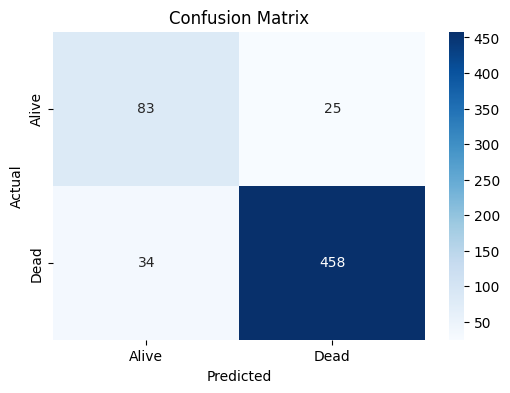

ROC AUC Score: 0.9413203854260765


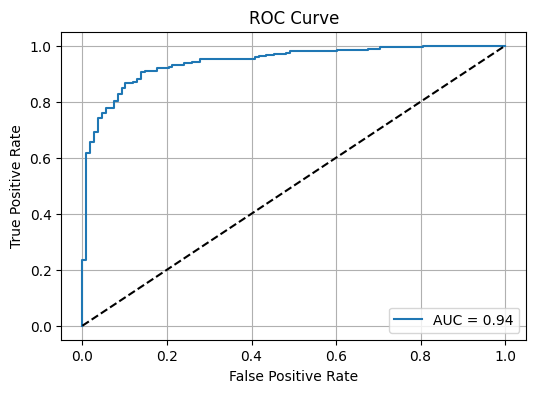

In [126]:
y_pred = best_cat.predict(X_test)
y_pred_proba = best_cat.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_outcome.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_outcome.classes_, yticklabels=le_outcome.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

if y_pred_proba is not None:
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    print("ROC AUC Score:", auc_score)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    print("ROC AUC Score and Curve not available (model does not support probability estimates).")

Brier Score: 0.07677474685810817


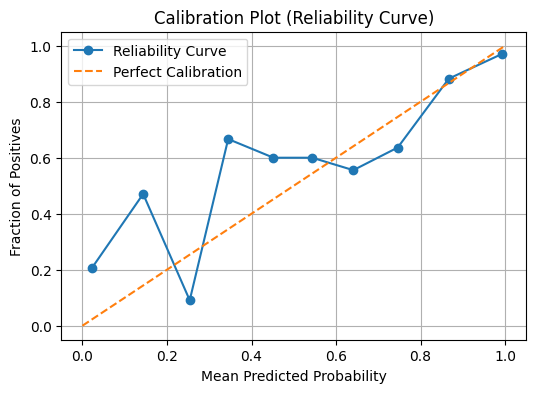

PR AUC Score: 0.9856001399527488


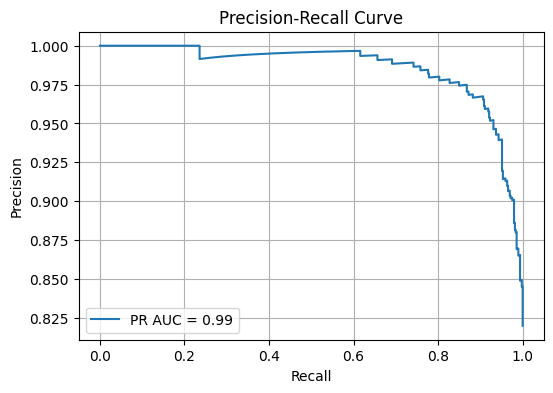

ROC AUC 95% CI: (0.917, 0.962)
PR AUC 95% CI: (0.977, 0.992)


In [127]:
if y_pred_proba is not None:
    brier_score = brier_score_loss(y_test, y_pred_proba)
    print("Brier Score:", brier_score)

    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(6,4))
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot (Reliability Curve)')
    plt.legend()
    plt.grid()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    print("PR AUC Score:", pr_auc)

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    n_bootstraps = 1000
    rng = np.random.RandomState(42)
    roc_auc_scores = []
    pr_auc_scores = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_test), len(y_test))
        if len(np.unique(y_test.iloc[indices])) < 2:
            continue
        score_roc = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
        score_pr = average_precision_score(y_test.iloc[indices], y_pred_proba[indices])
        roc_auc_scores.append(score_roc)
        pr_auc_scores.append(score_pr)

    roc_ci_lower = np.percentile(roc_auc_scores, 2.5)
    roc_ci_upper = np.percentile(roc_auc_scores, 97.5)
    pr_ci_lower = np.percentile(pr_auc_scores, 2.5)
    pr_ci_upper = np.percentile(pr_auc_scores, 97.5)

    print(f"ROC AUC 95% CI: ({roc_ci_lower:.3f}, {roc_ci_upper:.3f})")
    print(f"PR AUC 95% CI: ({pr_ci_lower:.3f}, {pr_ci_upper:.3f})")
